## Download and process for adding sequences to .var

#### Download annData

In [3]:
# Data download
!wget https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_Controller/10k_PBMC_3p_nextgem_Chromium_Controller_raw_feature_bc_matrix.h5
!wget https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_Controller/10k_PBMC_3p_nextgem_Chromium_Controller_molecule_info.h5

--2025-07-04 10:02:29--  https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_Controller/10k_PBMC_3p_nextgem_Chromium_Controller_raw_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 2606:4700::6812:ad, 2606:4700::6812:1ad, 104.18.1.173, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|2606:4700::6812:ad|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55493959 (53M) [binary/octet-stream]
Saving to: ‘10k_PBMC_3p_nextgem_Chromium_Controller_raw_feature_bc_matrix.h5’

10k_PBMC_3p_nextgem 100%[===================>]  52.92M  14.0MB/s    in 3.8s    

2025-07-04 10:02:34 (14.0 MB/s) - ‘10k_PBMC_3p_nextgem_Chromium_Controller_raw_feature_bc_matrix.h5’ saved [55493959/55493959]

--2025-07-04 10:02:34--  https://cf.10xgenomics.com/samples/cell-exp/6.1.0/10k_PBMC_3p_nextgem_Chromium_Controller/10k_PBMC_3p_nextgem_Chromium_Controller_molecule_info.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 2606:4700::

#### Run preprocessing script

In [ ]:
# Run preprocessing script
!python ../scripts/preprocess_pbmc.py \
  --input_h5 ../../data/raw/10k_PBMC_3p_nextgem_Chromium_Controller_raw_feature_bc_matrix.h5 \
  --fasta ../../data/gencode/gencode.v43.transcripts.fa \
  --output ../../data/processed/pbmc/pbmc_10k_preprocessed_with_obs.h5ad

#### Load the result

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import issparse

adata = sc.read_h5ad("../data/processed/pbmc/pbmc_10k_preprocessed_with_obs.h5ad")
adata

AnnData object with n_obs × n_vars = 2099284 × 36601
    obs: 'source', 'batch', 'mt_frac', 'n_counts', 'n_genes', 'cell_id'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_id_clean', 'sequence'

#### Inspect .X, .obs, .var

In [2]:
import scipy.sparse as sp

print(">>> .X (expression matrix):")
print("Shape:", adata.shape)
print("Sparse Type:", type(adata.X))
print("Non-zero Elements:", adata.X.nnz if sp.issparse(adata.X) else np.count_nonzero(adata.X))
mean_expr = adata.X[:, :5].mean(axis=0).A1 if sp.issparse(adata.X) else adata.X[:, :5].mean(axis=0)
print("Mean expression of first 5 genes:", mean_expr)

print("\n>>> .obs:")
print(adata.obs.head())

print("\n>>> .var:")
print(adata.var[["gene_id_clean", "sequence"]].head())
missing = adata.var["sequence"].isnull().sum() + (adata.var["sequence"] == "").sum()
print(f"Missing sequences in `.var['sequence']`: {missing} / {adata.var.shape[0]}")

>>> .X (expression matrix):
Shape: (2099284, 36601)
Sparse Type: <class 'scipy.sparse._csr.csr_matrix'>
Non-zero Elements: 27687445
Mean expression of first 5 genes: [0.0000000e+00 0.0000000e+00 0.0000000e+00 1.4766945e-05 4.7635288e-07]

>>> .obs:
                     source    batch  mt_frac  n_counts  n_genes  \
AAACCCAAGAAACCAT-1  PBMC10k  PBMC10k      NaN       0.0        0   
AAACCCAAGAAACCCA-1  PBMC10k  PBMC10k      0.0       1.0        1   
AAACCCAAGAAACCCG-1  PBMC10k  PBMC10k      NaN       0.0        0   
AAACCCAAGAAACTAC-1  PBMC10k  PBMC10k      0.0       1.0        1   
AAACCCAAGAAACTCA-1  PBMC10k  PBMC10k      0.0       2.0        2   

                               cell_id  
AAACCCAAGAAACCAT-1  AAACCCAAGAAACCAT-1  
AAACCCAAGAAACCCA-1  AAACCCAAGAAACCCA-1  
AAACCCAAGAAACCCG-1  AAACCCAAGAAACCCG-1  
AAACCCAAGAAACTAC-1  AAACCCAAGAAACTAC-1  
AAACCCAAGAAACTCA-1  AAACCCAAGAAACTCA-1  

>>> .var:
               gene_id_clean  \
index                          
MIR1302-2HG  ENSG0000

#### Inspect gene ID structure

In [3]:
print("PBMC: .var index:", adata.var.index[:5].tolist())
print("PBMC: .var['gene_id_clean']:", adata.var['gene_id_clean'].unique()[:5])
if "gene_ids" in adata.var.columns:
    print("PBMC: .var['gene_ids'] sample:")
    print(adata.var['gene_ids'].explode().unique()[:5])

PBMC: .var index: ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3']
PBMC: .var['gene_id_clean']: ['ENSG00000243485' 'ENSG00000237613' 'ENSG00000186092' 'ENSG00000238009'
 'ENSG00000239945']
PBMC: .var['gene_ids'] sample:
['ENSG00000243485' 'ENSG00000237613' 'ENSG00000186092' 'ENSG00000238009'
 'ENSG00000239945']


#### QC visualizations

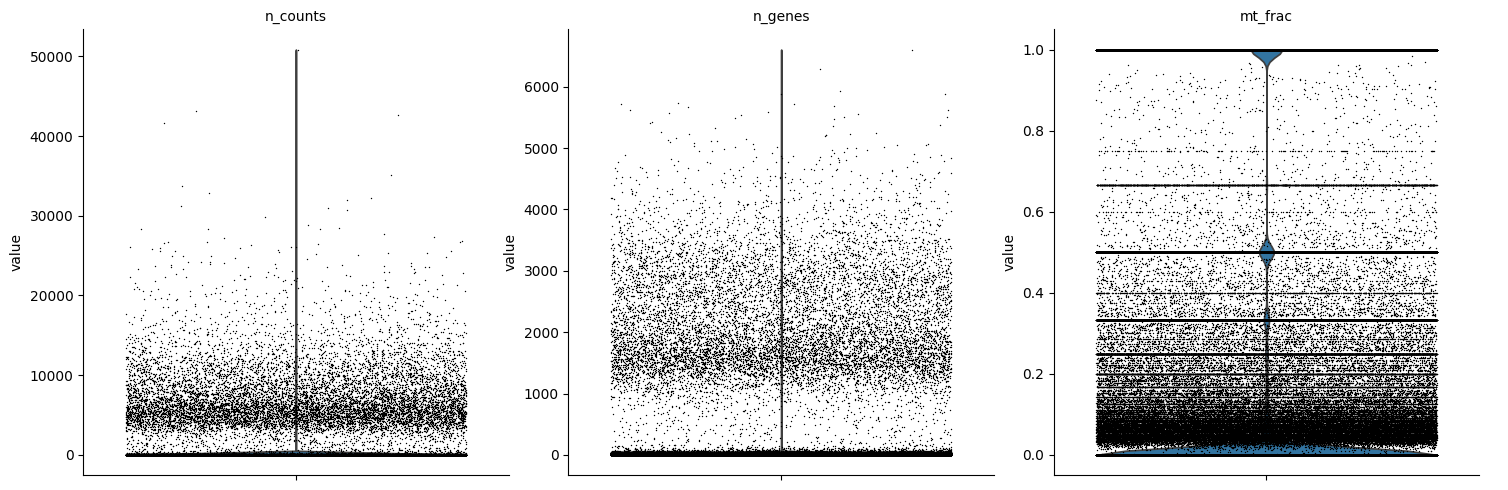

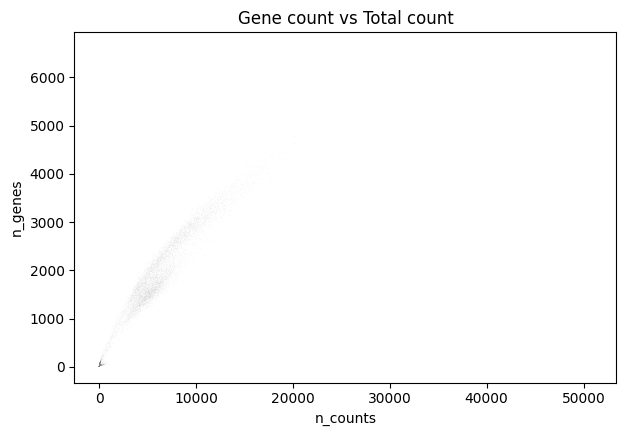

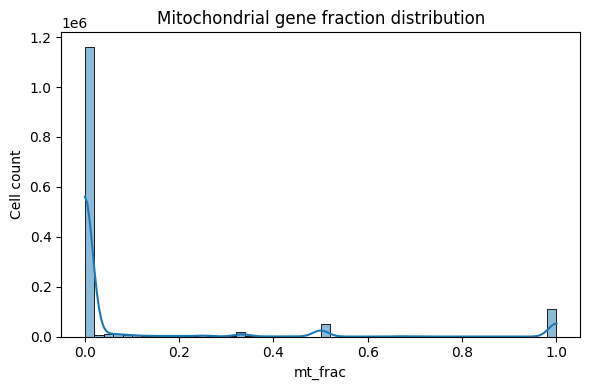

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Violin plots
sc.pl.violin(adata, ['n_counts', 'n_genes', 'mt_frac'], jitter=0.4, multi_panel=True)

# Scatter plot
sc.pl.scatter(adata, x='n_counts', y='n_genes', title="Gene count vs Total count")

# Histogram of mitochondrial fraction
plt.figure(figsize=(6, 4))
sns.histplot(adata.obs["mt_frac"], bins=50, kde=True)
plt.title("Mitochondrial gene fraction distribution")
plt.xlabel("mt_frac")
plt.ylabel("Cell count")
plt.tight_layout()
plt.show()

#### PCA and UMAP embedding

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='mt_frac')

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['n_counts', 'n_genes', 'mt_frac'])

/home/ubuntu/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/home/ubuntu/.local/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
